### EMG Signal Processing

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [5]:
data_folder = 'N_TXT'
data_filenames = ['5Nsen.txt', '5Npie.txt', '5Nmar.txt']
trial_names = ['Sit', 'Stand', 'Gait']
channel_names = ['rectus femoris', 'biceps femoris', 'vastus internus', 'semitendinosus']
sample_rate = 1000

#### Data Loading from file

In [7]:
import os
def load_lower_limb_txt(_filepath):
    with open(_filepath) as fp:
        collect_values = np.array([])
        lines = fp.readlines()
        for line in lines[7:]:  # first few lines are data description
            items = [float(e) for e in line.split('\t')[:4] if e != '']  # last column is not EMG data
            if len(items) != 4:  # last few rows might not have EMG data
                continue
            collect_values = np.concatenate((collect_values, np.array(items)))
    _data = collect_values.reshape(-1, 4)
    return _data


all_data = []
for i in range(len(data_filenames)):
    filepath = os.path.join(data_folder, data_filenames[i])
    data = load_lower_limb_txt(filepath)
    all_data.append(data)

print(all_data)
# filepath = os.path.join("A_TXT/", '3Asen.txt')
# data = load_lower_limb_txt(filepath)
# data

[array([[ 0.0007, -0.0015, -0.0008,  0.003 ],
       [ 0.0075, -0.0015, -0.0023,  0.    ],
       [ 0.003 , -0.0015, -0.0008,  0.    ],
       ...,
       [-0.0015,  0.    , -0.0008,  0.003 ],
       [-0.0015,  0.    , -0.0008,  0.003 ],
       [-0.0015,  0.    , -0.0008,  0.003 ]]), array([[ 0.0045,  0.0022,  0.0007,  0.0037],
       [ 0.0142, -0.006 ,  0.0007,  0.    ],
       [ 0.0165, -0.006 ,  0.    ,  0.    ],
       ...,
       [ 0.0022,  0.0037, -0.0068,  0.0037],
       [ 0.0022,  0.0037, -0.0068,  0.0037],
       [ 0.0022,  0.0037, -0.0068,  0.0037]]), array([[ 0.0037, -0.0015, -0.0008, -0.0173],
       [ 0.0015, -0.0015, -0.0015, -0.006 ],
       [ 0.    , -0.0015,  0.    , -0.012 ],
       ...,
       [-0.003 , -0.0038, -0.0008,  0.0645],
       [-0.0053, -0.0015,  0.0015,  0.0622],
       [ 0.    , -0.0015, -0.0105, -0.0181]])]


In [8]:
for k in range(len(all_data)):
    print(f'data shape of {k:6}: {all_data[k].shape}')

data shape of      0: (13480, 4)
data shape of      1: (15260, 4)
data shape of      2: (6563, 4)


In [10]:
import pyemgpipeline as pep
from matplotlib.figure import SubplotParams

emg_plot_params = pep.plots.EMGPlotParams(
    n_rows=1,
    n_cols=4,
    fig_kwargs={
        'figsize': (16, 1.2),
        'subplotpars': SubplotParams(top=0.7, wspace=0.1, hspace=0),
    },
    line2d_kwargs={
        'color': 'b',
    }
)

In [11]:
c = pep.wrappers.EMGMeasurementCollection(all_data, hz=sample_rate, trial_names=trial_names,
                                          channel_names=channel_names, emg_plot_params=emg_plot_params)

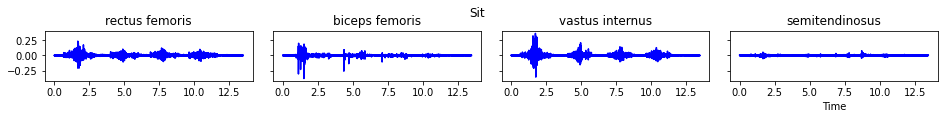

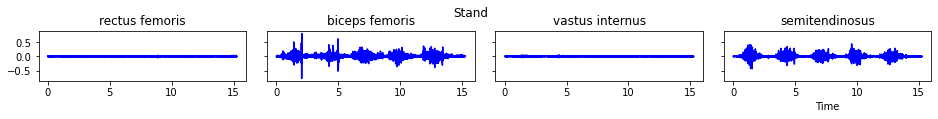

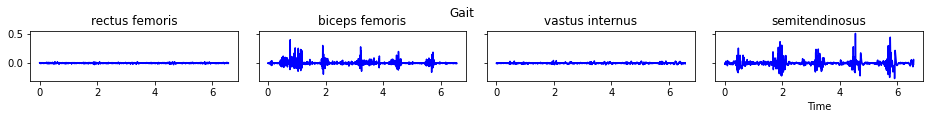

In [12]:
c.plot()

### 1. DC Offset Removal

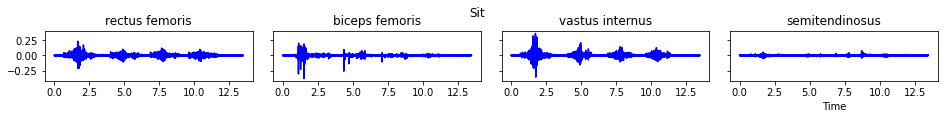

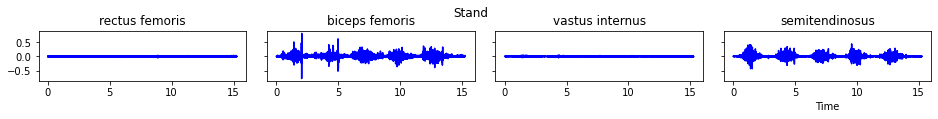

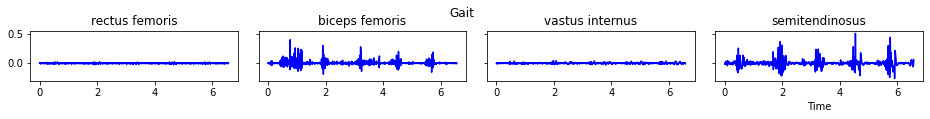

In [13]:
c.apply_dc_offset_remover()
c.plot()

### 2. Bandpass Filtering

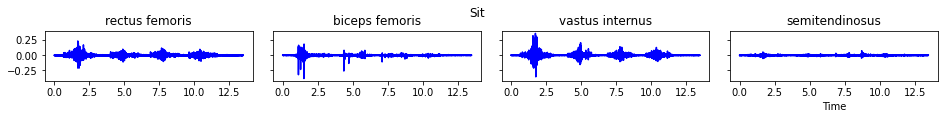

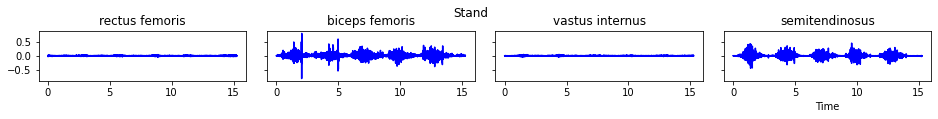

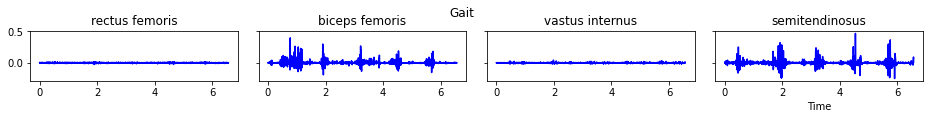

In [14]:
c.apply_bandpass_filter(bf_order=4, bf_cutoff_fq_lo=10, bf_cutoff_fq_hi=450)
c.plot()

### 3. Fullwave Recification

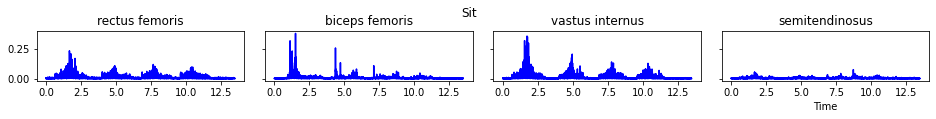

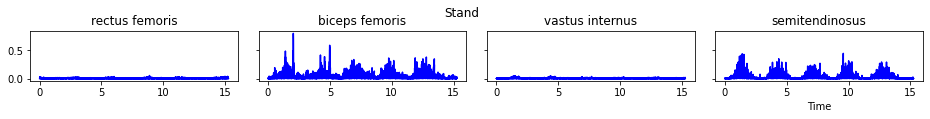

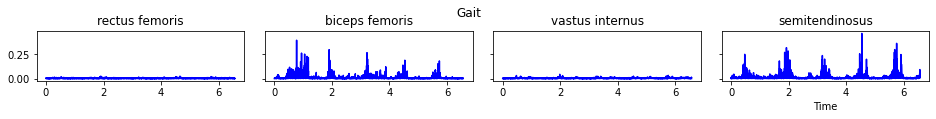

In [15]:
c.apply_full_wave_rectifier()
c.plot()

### 4. Linear Envelope

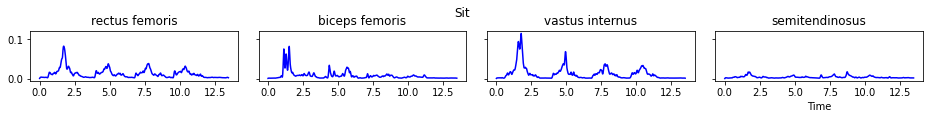

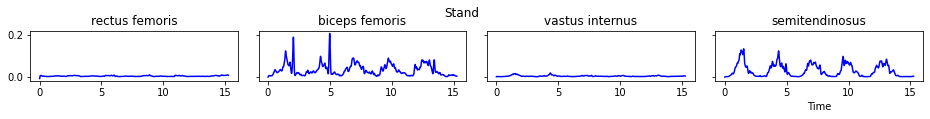

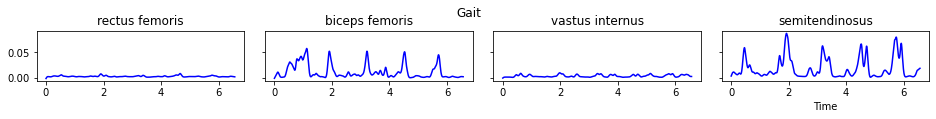

In [16]:
c.apply_linear_envelope(le_order=4, le_cutoff_fq=6)
c.plot()

### 5. End Frame Cutting

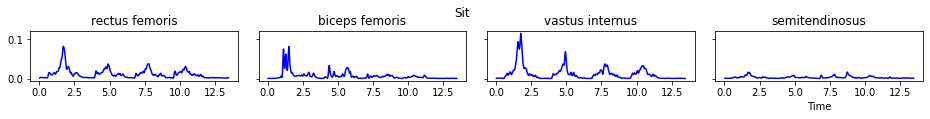

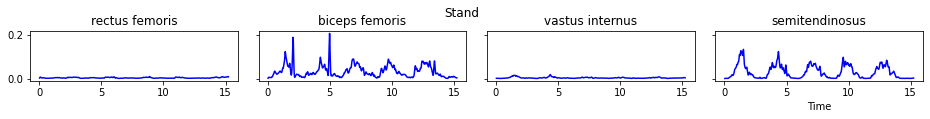

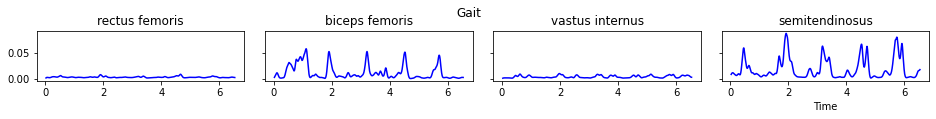

In [17]:
c.apply_end_frame_cutter(n_end_frames=30)
c.plot()

### 6. Amplitude Normalization

In [18]:
max_amplitude = c.find_max_amplitude_of_each_channel_across_trials()
print('max_amplitude:', max_amplitude)

max_amplitude: [0.08272218 0.20556472 0.11531935 0.13300577]


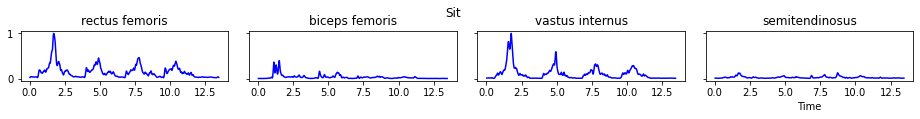

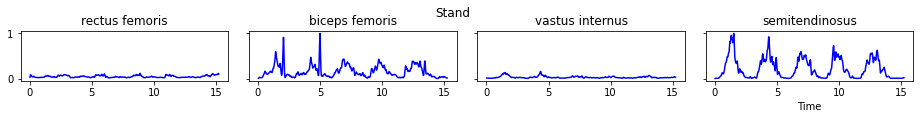

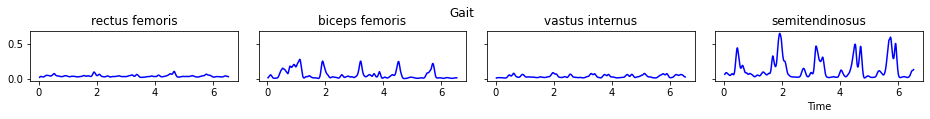

In [19]:
c.apply_amplitude_normalizer(max_amplitude)
c.plot()

### 7. Segmentation

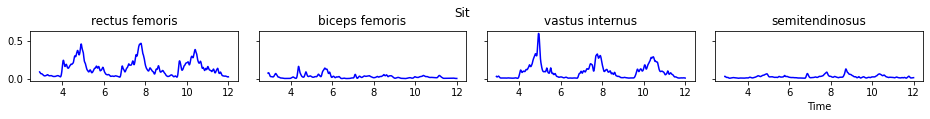

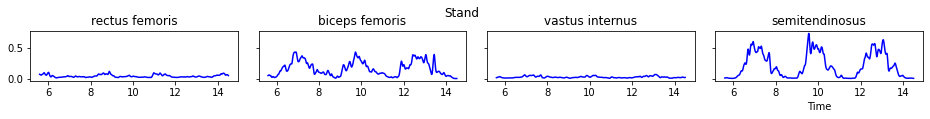

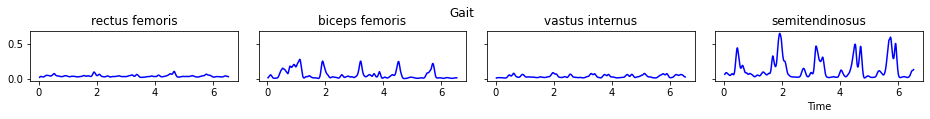

In [20]:
all_beg_ts = [2.9, 5.6, 0]
all_end_ts = [12, 14.5, 999]
c.apply_segmenter(all_beg_ts, all_end_ts)
c.plot()

In [21]:
c.all_data

[array([[0.0920687 , 0.07740053, 0.03412713, 0.03382395],
        [0.09163069, 0.07772384, 0.03371283, 0.03392962],
        [0.09118   , 0.07803646, 0.03330972, 0.03402932],
        ...,
        [0.02820274, 0.00735341, 0.01221804, 0.01764664],
        [0.02831608, 0.0073656 , 0.01220219, 0.01761076],
        [0.02843199, 0.00737811, 0.01218871, 0.01757233]]),
 array([[0.07723283, 0.05704184, 0.02298162, 0.01810079],
        [0.07700917, 0.05733228, 0.02309847, 0.0180855 ],
        [0.07679376, 0.05763172, 0.02321987, 0.01807356],
        ...,
        [0.05755993, 0.00988673, 0.02684806, 0.01269028],
        [0.05715868, 0.00993258, 0.0269777 , 0.01266372],
        [0.05676127, 0.00998159, 0.0271074 , 0.01263688]]),
 array([[0.01953295, 0.01334102, 0.00961191, 0.06336577],
        [0.02025041, 0.01389486, 0.00986346, 0.06437713],
        [0.02094466, 0.01444859, 0.01010689, 0.06536599],
        ...,
        [0.02983576, 0.01265461, 0.02532435, 0.13096556],
        [0.02970596, 0.012626

#### Export the processed data

In [22]:
all_csv_path = ['ex2_sit.csv', 'ex2_stand.csv', 'ex2_gait.csv']
c.export_csv(all_csv_path)

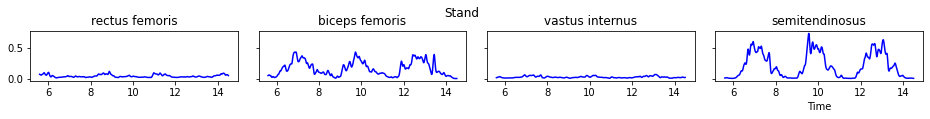

In [23]:
c[1].plot()

### Model Building

In [24]:
df_sit = pd.read_csv('ex2_sit.csv')
df_stand = pd.read_csv('ex2_stand.csv')
df_gait = pd.read_csv('ex2_gait.csv')

In [26]:
df_sit["action"] = "sit"

In [29]:
df_stand["action"] = "stand"
df_gait["action"] = "gait"

In [33]:
df = pd.concat([df_sit, df_stand, df_gait], ignore_index=True)
df.head()

,Timestamp,rectus femoris,biceps femoris,vastus internus,semitendinosus,action
0,2.900,0.092069,0.077401,0.034127,0.033824,sit
1,2.901,0.091631,0.077724,0.033713,0.033930,sit
2,2.902,0.091180,0.078036,0.033310,0.034029,sit
3,2.903,0.090717,0.078338,0.032918,0.034122,sit
4,2.904,0.090241,0.078630,0.032538,0.034207,sit


In [34]:
df["action"].value_counts()

sit      9101
stand    8901
gait     6503
Name: action, dtype: int64

In [39]:
X = df.drop(['Timestamp', 'action'], axis="columns")
Y = df["action"]

In [40]:
print(X.shape)
print(Y.shape)

(24505, 4)
(24505,)


In [52]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=20)

### Logistic Regression

In [38]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

In [53]:
scaled_train_df = X_train
model = LogisticRegression(solver='liblinear',random_state=50)
model.fit(scaled_train_df,y_train)
pred_y = model.predict(X_test)
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_test,pred_y))
print(confusion_matrix(y_test,pred_y))

              precision    recall  f1-score   support

        gait       0.73      0.80      0.77      1904
         sit       0.78      0.80      0.79      2728
       stand       0.82      0.75      0.78      2720

    accuracy                           0.78      7352
   macro avg       0.78      0.78      0.78      7352
weighted avg       0.79      0.78      0.78      7352

[[1528    3  373]
 [ 471 2191   66]
 [  80  605 2035]]


### Decision Tree

In [42]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
clf = GridSearchCV(DecisionTreeClassifier(), {'criterion':['gini', 'entropy']}, cv=10, return_train_score=False)
clf.fit(X, Y)
clf.cv_results_

{'mean_fit_time': array([0.06401739, 0.08989258]),
 'std_fit_time': array([0.0012885 , 0.00361045]),
 'mean_score_time': array([0.00262182, 0.00250723]),
 'std_score_time': array([0.0004657 , 0.00050782]),
 'param_criterion': masked_array(data=['gini', 'entropy'],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'params': [{'criterion': 'gini'}, {'criterion': 'entropy'}],
 'split0_test_score': array([0.80946552, 0.8127295 ]),
 'split1_test_score': array([0.81680947, 0.8000816 ]),
 'split2_test_score': array([0.86168911, 0.9126887 ]),
 'split3_test_score': array([0.88208894, 0.88086495]),
 'split4_test_score': array([0.85393717, 0.94410445]),
 'split5_test_score': array([0.88489796, 0.97142857]),
 'split6_test_score': array([0.70857143, 0.73959184]),
 'split7_test_score': array([0.86693878, 0.92612245]),
 'split8_test_score': array([0.86571429, 0.89632653]),
 'split9_test_score': array([0.85755102, 0.86734694]),
 'mean_test_score': array([0.8407663

In [43]:
dt_result_df = pd.DataFrame(clf.cv_results_)
dt_result_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.064017,0.001289,0.002622,0.000466,gini,{'criterion': 'gini'},0.809466,0.816809,0.861689,0.882089,0.853937,0.884898,0.708571,0.866939,0.865714,0.857551,0.840766,0.049885,2
1,0.089893,0.003610,0.002507,0.000508,entropy,{'criterion': 'entropy'},0.812729,0.800082,0.912689,0.880865,0.944104,0.971429,0.739592,0.926122,0.896327,0.867347,0.875129,0.068177,1


In [44]:
dt_result_df[['param_criterion', 'mean_test_score']]

,param_criterion,mean_test_score
0,gini,0.840766
1,entropy,0.875129


In [59]:
from sklearn.metrics import accuracy_score

dt_model = DecisionTreeClassifier(criterion="entropy")
dt_model.fit(scaled_train_df,y_train)
predicted_values = dt_model.predict(X_test)
x = accuracy_score(y_test, predicted_values)
print("DecisionTrees's Accuracy is: ", x*100)
print(classification_report(y_test,predicted_values))

print("Confusion Matrix\n")
print(confusion_matrix(y_test,predicted_values))

DecisionTrees's Accuracy is:  99.64635473340587
              precision    recall  f1-score   support

        gait       0.99      1.00      0.99      1904
         sit       1.00      1.00      1.00      2728
       stand       1.00      1.00      1.00      2720

    accuracy                           1.00      7352
   macro avg       1.00      1.00      1.00      7352
weighted avg       1.00      1.00      1.00      7352

Confusion Matrix

[[1895    5    4]
 [   6 2722    0]
 [   8    3 2709]]


### Random Forest

In [45]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = GridSearchCV(RandomForestClassifier(), {'n_estimators':[1, 5, 10, 20, 40, 50,60]}, cv=10, return_train_score=False)
rf_clf.fit(X, Y)
rf_clf.cv_results_

{'mean_fit_time': array([0.03289788, 0.10759676, 0.20488958, 0.38409128, 0.73136659,
        0.92470238, 1.11731462]),
 'std_fit_time': array([0.00186832, 0.00374769, 0.01128221, 0.01053633, 0.01328049,
        0.0180283 , 0.02385062]),
 'mean_score_time': array([0.00280213, 0.00370193, 0.00479622, 0.00599942, 0.00950127,
        0.01110141, 0.01270301]),
 'std_score_time': array([4.00978672e-04, 7.82654771e-04, 7.52752216e-04, 7.02360254e-06,
        4.99588685e-04, 2.99966808e-04, 6.37226748e-04]),
 'param_n_estimators': masked_array(data=[1, 5, 10, 20, 40, 50, 60],
              mask=[False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_estimators': 1},
  {'n_estimators': 5},
  {'n_estimators': 10},
  {'n_estimators': 20},
  {'n_estimators': 40},
  {'n_estimators': 50},
  {'n_estimators': 60}],
 'split0_test_score': array([0.86332109, 0.84659323, 0.84006528, 0.8620971 , 0.86536108,
        0.84863321, 0.85189718]),
 's

In [46]:
rf_result_df = pd.DataFrame(rf_clf.cv_results_)
rf_result_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.032898,0.001868,0.002802,0.000401,1,{'n_estimators': 1},0.863321,0.785394,0.933089,0.818849,0.955528,0.899184,0.679184,0.919184,0.887347,0.826122,0.856720,0.078268,7
1,0.107597,0.003748,0.003702,0.000783,5,{'n_estimators': 5},0.846593,0.771522,0.942472,0.885353,0.944920,0.980816,0.726939,0.936327,0.895102,0.851429,0.878147,0.076684,4
2,0.204890,0.011282,0.004796,0.000753,10,{'n_estimators': 10},0.840065,0.811098,0.940024,0.876377,0.958792,0.974286,0.728980,0.902041,0.875918,0.860408,0.876799,0.069748,5
3,0.384091,0.010536,0.005999,0.000007,20,{'n_estimators': 20},0.862097,0.788250,0.914729,0.878825,0.946144,0.967755,0.768571,0.896735,0.872653,0.856327,0.875209,0.059248,6
4,0.731367,0.013280,0.009501,0.000500,40,{'n_estimators': 40},0.865361,0.821297,0.951040,0.901673,0.973888,0.977551,0.766122,0.896327,0.879184,0.873061,0.890550,0.062991,2
5,0.924702,0.018028,0.011101,0.000300,50,{'n_estimators': 50},0.848633,0.822113,0.943696,0.898409,0.962056,0.968163,0.746531,0.886531,0.880000,0.877551,0.883368,0.064020,3
6,1.117315,0.023851,0.012703,0.000637,60,{'n_estimators': 60},0.851897,0.813545,0.938392,0.913505,0.971848,0.969796,0.764490,0.917143,0.886531,0.881224,0.890837,0.063111,1


In [47]:
rf_result_df[['param_n_estimators', 'mean_test_score']]

,param_n_estimators,mean_test_score
0,1,0.856720
1,5,0.878147
2,10,0.876799
3,20,0.875209
4,40,0.890550
5,50,0.883368
6,60,0.890837


In [58]:
rf_model = RandomForestClassifier(n_estimators=60,random_state=30)
rf_model.fit(scaled_train_df,y_train)
pred = rf_model.predict(X_test)
print("Classification Report \n")
print(classification_report(y_test,pred))
print("Confusion Matrix\n")
print(confusion_matrix(y_test,pred))

Classification Report 

              precision    recall  f1-score   support

        gait       1.00      1.00      1.00      1904
         sit       1.00      1.00      1.00      2728
       stand       1.00      1.00      1.00      2720

    accuracy                           1.00      7352
   macro avg       1.00      1.00      1.00      7352
weighted avg       1.00      1.00      1.00      7352

Confusion Matrix

[[1904    0    0]
 [   0 2728    0]
 [   1    0 2719]]


### SVM

In [48]:
from sklearn.svm import SVC
svm_clf = GridSearchCV(SVC(), {'C': [1,10,20], 'kernel': ['rbf','linear']}, cv=10, return_train_score=False)
svm_clf.fit(X, Y)
svm_clf.cv_results_

{'mean_fit_time': array([2.27492626, 3.29044423, 1.55203664, 2.57837415, 1.41780169,
        2.39449508]),
 'std_fit_time': array([0.09191967, 0.21041864, 0.14627868, 0.22002041, 0.15715957,
        0.21849822]),
 'mean_score_time': array([0.20524693, 0.18409541, 0.13179259, 0.15728166, 0.11763771,
        0.14872913]),
 'std_score_time': array([0.00982332, 0.0120073 , 0.01036059, 0.01049508, 0.01217676,
        0.01017942]),
 'param_C': masked_array(data=[1, 1, 10, 10, 20, 20],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_kernel': masked_array(data=['rbf', 'linear', 'rbf', 'linear', 'rbf', 'linear'],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 1, 'kernel': 'rbf'},
  {'C': 1, 'kernel': 'linear'},
  {'C': 10, 'kernel': 'rbf'},
  {'C': 10, 'kernel': 'linear'},
  {'C': 20, 'kernel': 'rbf'},
  {'C': 20, 'kernel': 'linear'}],


In [49]:
svm_result_df = pd.DataFrame(svm_clf.cv_results_)
svm_result_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,2.274926,0.091920,0.205247,0.009823,1,rbf,"{'C': 1, 'kernel': 'rbf'}",0.704610,0.852713,0.985312,0.861281,0.928193,0.980408,0.766122,0.940816,0.926122,0.843265,0.878884,0.086881,3
1,3.290444,0.210419,0.184095,0.012007,1,linear,"{'C': 1, 'kernel': 'linear'}",0.707058,0.762546,0.844145,0.634843,0.924929,0.882449,0.545714,0.938776,0.898776,0.710204,0.784944,0.126943,6
2,1.552037,0.146279,0.131793,0.010361,10,rbf,"{'C': 10, 'kernel': 'rbf'}",0.723378,0.847001,0.983272,0.881681,0.927377,0.969796,0.760816,0.951020,0.927755,0.854694,0.882679,0.082881,1
3,2.578374,0.220020,0.157282,0.010495,10,linear,"{'C': 10, 'kernel': 'linear'}",0.660139,0.768258,0.827417,0.729090,0.928601,0.884898,0.500408,0.952653,0.888163,0.739592,0.787922,0.131573,5
4,1.417802,0.157160,0.117638,0.012177,20,rbf,"{'C': 20, 'kernel': 'rbf'}",0.734802,0.822113,0.968584,0.880865,0.915545,0.969388,0.757143,0.957959,0.927347,0.860408,0.879415,0.080826,2
5,2.394495,0.218498,0.148729,0.010179,20,linear,"{'C': 20, 'kernel': 'linear'}",0.660547,0.768258,0.827417,0.736842,0.930641,0.883673,0.497959,0.954286,0.886531,0.748980,0.789513,0.131639,4


In [50]:
svm_result_df[['param_C', 'param_kernel', 'mean_test_score']]

,param_C,param_kernel,mean_test_score
0,1,rbf,0.878884
1,1,linear,0.784944
2,10,rbf,0.882679
3,10,linear,0.787922
4,20,rbf,0.879415
5,20,linear,0.789513


SVM's Accuracy is:  0.9439608269858542
              precision    recall  f1-score   support

        gait       0.96      0.94      0.95      1904
         sit       0.98      0.91      0.94      2728
       stand       0.91      0.99      0.95      2720

    accuracy                           0.94      7352
   macro avg       0.95      0.94      0.94      7352
weighted avg       0.95      0.94      0.94      7352

[[1787   38   79]
 [  69 2470  189]
 [  13   24 2683]]


<AxesSubplot:>

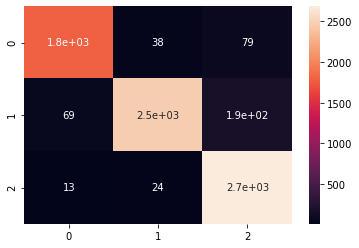

In [62]:
import seaborn as sns

SVM = SVC(kernel='rbf', C=10)
SVM.fit(scaled_train_df,y_train)
predicted_values = SVM.predict(X_test)
x = accuracy_score(y_test, predicted_values)
print("SVM's Accuracy is: ", x)
print(classification_report(y_test,predicted_values))

cf_matrix = confusion_matrix(y_test,predicted_values)
print(cf_matrix)
sns.heatmap(cf_matrix, annot=True)
# print(confusion_matrix(y_test,predicted_values))

### Save the Model

#### The performance of SVM is good without any overfitting

In [64]:
import pickle
with open('model/svm_model','wb') as f:
    pickle.dump(SVM, f) 

### EMG Signal Analysis on single class data

In [26]:
import os
import pyemgpipeline as pep
from matplotlib.figure import SubplotParams

In [27]:
data_folder = 'A_TXT'
data_filename = '3Asen.txt'
channel_names = ['rectus femoris', 'biceps femoris', 'vastus internus', 'semitendinosus']
trial_name = 'Sit'
sample_rate = 1000

In [ ]:
filepath = os.path.join(data_folder, data_filename)
data = load_uci_lower_limb_txt(filepath)
data

In [28]:
emg_plot_params = pep.plots.EMGPlotParams(
    n_rows=4,
    fig_kwargs={
        'figsize': (8, 6),
        'dpi': 80,
        'subplotpars': SubplotParams(wspace=0, hspace=0.6),
    },
    line2d_kwargs={
        'color': 'red',
    }
)

In [29]:
m = pep.wrappers.EMGMeasurement(data, hz=sample_rate,trial_name=trial_name, channel_names=channel_names, emg_plot_params=emg_plot_params)
emg_sig = pep.wrappers.EMGMeasurement(X.to_numpy(), hz=sample_rate,trial_name=trial_name, channel_names=channel_names, emg_plot_params=emg_plot_params)

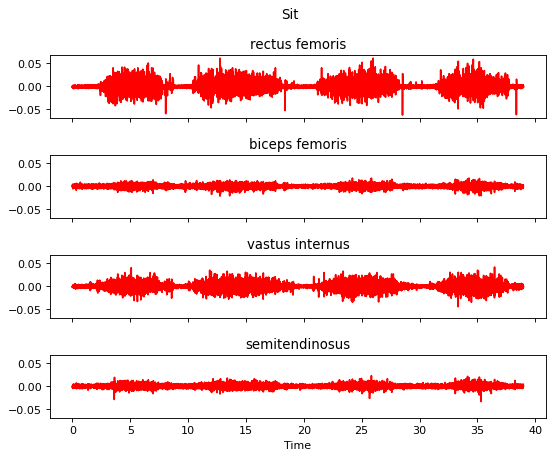

In [30]:
m.plot()

### 1.DC offset removal

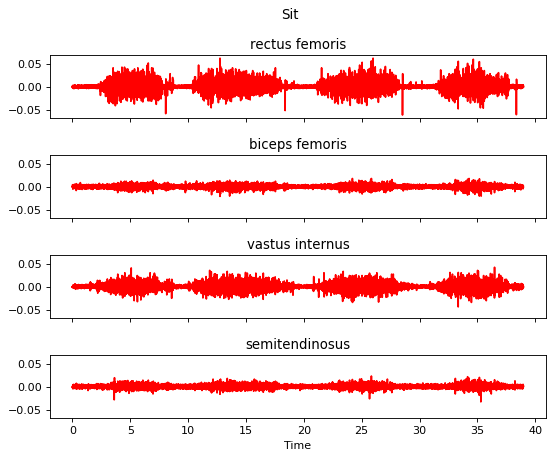

In [32]:
m.apply_dc_offset_remover()
emg_sig.apply_dc_offset_remover()
m.plot()

### 2.Bandpass filtering

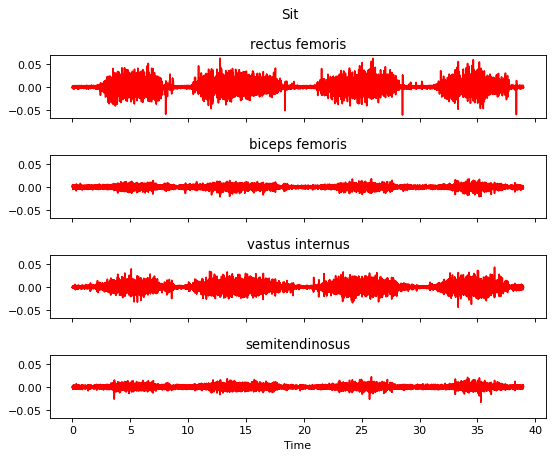

In [33]:
m.apply_bandpass_filter(bf_order=4, bf_cutoff_fq_lo=10, bf_cutoff_fq_hi=450)
emg_sig.apply_bandpass_filter(bf_order=4, bf_cutoff_fq_lo=10, bf_cutoff_fq_hi=450)
m.plot()

### 3.Full wave rectification

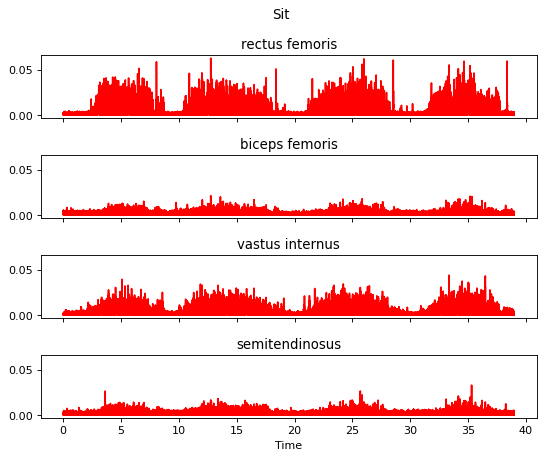

In [34]:
m.apply_full_wave_rectifier()
emg_sig.apply_full_wave_rectifier()
m.plot()

### 4.Linear envelope

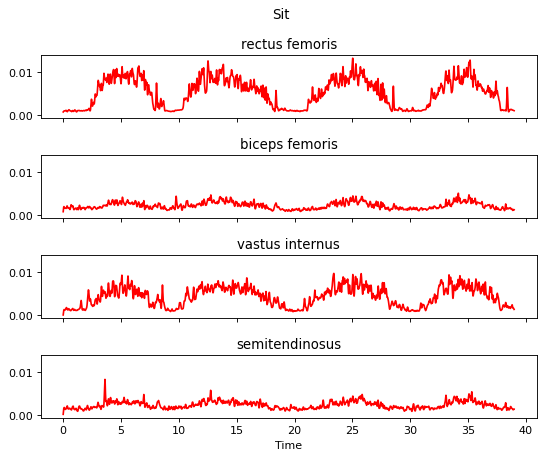

In [35]:
m.apply_linear_envelope(le_order=4, le_cutoff_fq=6)
emg_sig.apply_linear_envelope(le_order=4, le_cutoff_fq=6)
m.plot()

### 5. End Frame Cutting

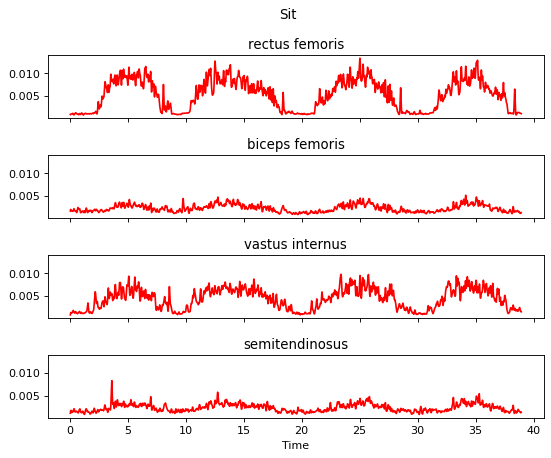

In [36]:
m.apply_end_frame_cutter(n_end_frames=30)
emg_sig.apply_end_frame_cutter(n_end_frames=30)
m.plot()

### 6. Amplitude Normalization

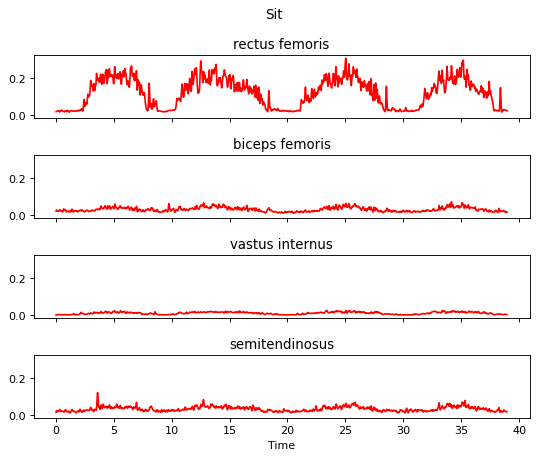

In [37]:
max_amplitude = [0.043, 0.069, 0.364, 0.068]  # assume the MVC is known
m.apply_amplitude_normalizer(max_amplitude)
emg_sig.apply_amplitude_normalizer(max_amplitude)
m.plot()

### 7. Segmentation

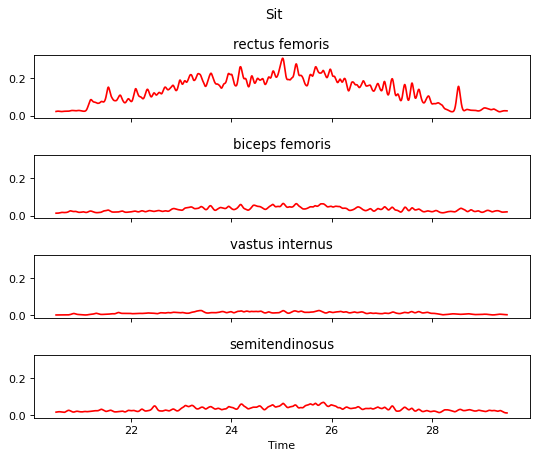

In [38]:
m.apply_segmenter(20.5, 29.5)
emg_sig.apply_segmenter(20.5, 29.5)
m.plot()

In [41]:
m.data
#emg_sig.data

array([[0.02186312, 0.01239804, 0.00273551, 0.01773494],
       [0.02193963, 0.0123964 , 0.00273592, 0.01775758],
       [0.02201485, 0.0123954 , 0.00273646, 0.01778186],
       ...,
       [0.02519068, 0.01955036, 0.00408111, 0.01343851],
       [0.02520053, 0.01955799, 0.00405828, 0.01344915],
       [0.02521111, 0.01956411, 0.00403501, 0.01346193]])

In [42]:
m.timestamp

array([20.5  , 20.501, 20.502, ..., 29.498, 29.499, 29.5  ])

#### Export the processed data

In [43]:
emg_sig.export_csv('emg_processed.csv')